In [55]:
import torch
import numpy as np
import sys
sys.path.append(r"..")
from model.cccnet import CCCNet
from dataloader.dataloader import get_dataLoader

model = CCCNet()
model.load_state_dict(torch.load(r"D:\Paper\PathPlan-main\trainLogs\2024_09_25_16_04_45\checkpoints\model_9.pth"))
test_loader = get_dataLoader("test")

In [103]:
model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataIter = iter(test_loader)
map, start, goal, path, filename, patharray = next(dataIter)
map, start, goal, path, filename, patharray = next(dataIter)
map, start, goal, path, filename, patharray = next(dataIter)
map, start, goal, path, filename, patharray = next(dataIter)
map, start, goal, path, filename, patharray = next(dataIter)
map, start, goal, path, patharray = map.to(device), start.to(device), goal.to(device), path.to(device), patharray.to(device)
model.to(device)
out = model(map, start, goal)
print(map.shape, start.shape, patharray.shape, out.shape)

torch.Size([32, 1, 100, 100]) torch.Size([32, 2]) torch.Size([32, 1, 10, 2]) torch.Size([32, 20])


In [57]:
def indexToMap(idx: torch.tensor) -> torch.tensor:
    image = torch.zeros((idx.shape[0], 100, 100))
    for i in range(idx.shape[0]):
        for j in range(10):
            rowIdx = int(idx[i][2 * j])
            colIdx = int(idx[i][2 * j + 1])
            if rowIdx >= 0 and rowIdx < 100 and colIdx >= 0 and colIdx < 100:
                image[i][rowIdx][colIdx] = 1
    
    return image

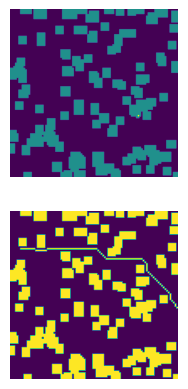

In [105]:
import matplotlib.pyplot as plt
image = torch.zeros((100, 100))
iterNum = 0
while (abs(out[0][-2] - goal[0][0]) > 5 or abs(out[0][-1] - goal[0][1]) > 5) and iterNum < 30:
    out = model(map, start, goal) * 100
    image_delta = indexToMap(out.cpu()[0].unsqueeze(0))
    image = image + image_delta
    if start[0][0] == out[0][-2] and start[0][1] == out[0][-1]:
        break
    start[0] = torch.tensor([int(out[0][-2]), int(out[0][-1])]).to('cuda')
    iterNum += 1

image[image >= 1] = 1
fig, axes = plt.subplots(2, 1)
axes[0].imshow(image.squeeze() + map[0][0].cpu())
axes[0].axis("off")
axes[1].imshow(path[0].cpu() + map[0][0].cpu())
axes[1].axis("off")
plt.show()

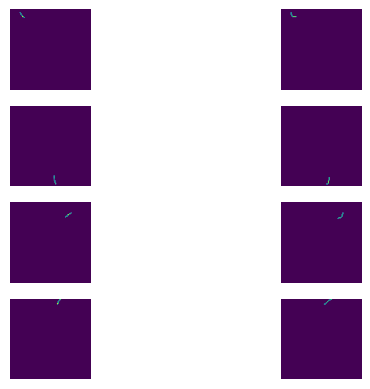

In [24]:
import matplotlib.pyplot as plt

patharray = patharray.squeeze()
image = indexToMap(out.cpu()[:4] * 100)
truth = indexToMap(torch.flatten(patharray.cpu()[:4], start_dim=1))

fig, axes = plt.subplots(4, 2)
for i in range(4):
    axes[i][0].imshow(image[i].cpu())
    axes[i][0].axis("off")
    axes[i][1].imshow(truth[i].cpu())
    axes[i][1].axis("off")